### Node Classification

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [29]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [5]:
dataset = Planetoid(root='./dataset/Cora', name='Cora', transform=NormalizeFeatures())

In [6]:
dataset
dataset[0]
dataset.num_classes
dataset.num_edge_features
dataset.num_node_features

Cora()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

7

0

1433

In [7]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
data['x']
data['x'].shape

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

torch.Size([2708, 1433])

In [9]:
data['edge_index']

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [10]:
data.num_nodes
data.num_node_types
data.num_edge_features
data.num_node_features

data.num_edges / data.num_nodes # node degree

2708

1

0

1433

3.8980797636632203

In [11]:
data['y'].unique()

tensor([0, 1, 2, 3, 4, 5, 6])

### lets build MLP first for comparison with GNN

In [12]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

In [13]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234)
        self.layer1 = Linear(in_features=dataset.num_node_features, out_features=hidden_channels)
        self.layer2 = Linear(in_features=hidden_channels, out_features=dataset.num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.layer2(x)
        return x    

In [14]:
model = MLP(hidden_channels=16)
print(model)

MLP(
  (layer1): Linear(in_features=1433, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=7, bias=True)
)


In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.01, weight_decay=5e-4)

In [16]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [17]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data['x'])
    loss = criterion(out[data['train_mask']], data['y'][data['train_mask']])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data['x'])
    pred = out.argmax(dim=1)
    test_correct = pred[data['test_mask']] == data['y'][data['test_mask']]
    test_acc = int(test_correct.sum() / int(data['test_mask'].sum()))
    return test_acc

In [18]:
for epoch in range(201):
    loss = train()
    if epoch % 20 == 0:
        print(f"epoch :: {epoch} ; loss :: {loss}")

epoch :: 0 ; loss :: 1.9575068950653076
epoch :: 20 ; loss :: 1.7407764196395874
epoch :: 40 ; loss :: 1.3391674757003784
epoch :: 60 ; loss :: 0.878396213054657
epoch :: 80 ; loss :: 0.642971396446228
epoch :: 100 ; loss :: 0.5997691750526428
epoch :: 120 ; loss :: 0.4719336926937103
epoch :: 140 ; loss :: 0.4569878578186035
epoch :: 160 ; loss :: 0.4068927466869354
epoch :: 180 ; loss :: 0.41471147537231445
epoch :: 200 ; loss :: 0.3913612961769104


In [19]:
model.eval()
out = model(data['x'])


pred = out.argmax(dim = 1)
pred

test_correct = pred[data['test_mask']] == data['y'][data['test_mask']]

test_correct.sum().item() / data['test_mask'].sum().item()

MLP(
  (layer1): Linear(in_features=1433, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=7, bias=True)
)

tensor([3, 4, 4,  ..., 5, 3, 3])

0.54

### Building a GNN

In [21]:
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels=dataset.num_node_features, out_channels=hidden_channels)
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=dataset.num_classes)
    
    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        return x

model = GNN(hidden_channels=16)

In [22]:
model

GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [23]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [24]:
model.eval()
out = model(data['x'], data['edge_index'])

GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [27]:
out.shape
out[:4]

torch.Size([2708, 7])

tensor([[ 0.0040,  0.0001,  0.0032,  0.0001, -0.0081,  0.0024,  0.0046],
        [ 0.0017,  0.0036, -0.0002, -0.0006, -0.0064,  0.0023,  0.0027],
        [ 0.0023,  0.0021,  0.0012, -0.0014, -0.0081,  0.0005,  0.0037],
        [-0.0052,  0.0076, -0.0043, -0.0014, -0.0019,  0.0034,  0.0094]],
       grad_fn=<SliceBackward0>)

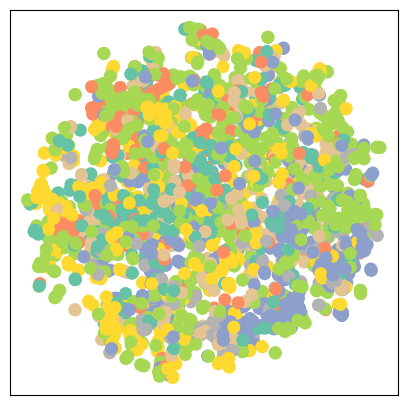

In [30]:
visualize(out, data['y'])

In [32]:
model = GNN(hidden_channels=16)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [33]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [34]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data['x'], data['edge_index'])
    loss = criterion(out[data['train_mask']], data['y'][data['train_mask']])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data['x'], data['edge_index'])
    pred = out.argmax(dim=1)
    test_correct = pred[data['test_mask']] == data['y'][data['test_mask']]
    test_acc = test_correct.sum().item() / data['test_mask'].sum().item()
    
    return test_acc

In [35]:
test() # before training

0.163

In [36]:
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f"epoch :: {epoch} ; train_loss :: {loss}")
    

epoch :: 10 ; train_loss :: 1.8689712285995483
epoch :: 20 ; train_loss :: 1.720018982887268
epoch :: 30 ; train_loss :: 1.5220853090286255
epoch :: 40 ; train_loss :: 1.342923641204834
epoch :: 50 ; train_loss :: 1.0884581804275513
epoch :: 60 ; train_loss :: 0.8925318717956543
epoch :: 70 ; train_loss :: 0.7580181956291199
epoch :: 80 ; train_loss :: 0.6782386302947998
epoch :: 90 ; train_loss :: 0.6168313026428223
epoch :: 100 ; train_loss :: 0.5410710573196411


In [37]:
test() # after training

0.813

GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

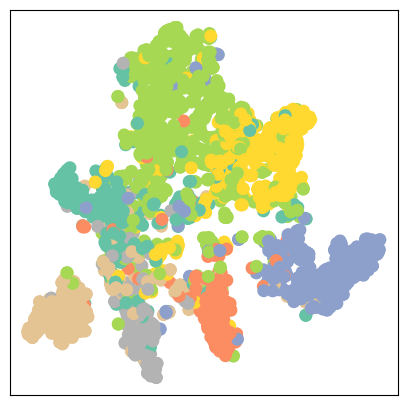

In [38]:
# visualization
model.eval()
out = model(data['x'], data['edge_index'])
visualize(out, data['y'])

#### How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

In [39]:
from torch_geometric.nn import GCNConv, GATConv

In [64]:
class GNN2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1= GCNConv(in_channels=dataset.num_node_features, out_channels=hidden_channels)
        self.conv2= GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.conv3= GCNConv(in_channels=hidden_channels, out_channels=dataset.num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p = 0.5, training=self.training)
        
        x = self.conv3(x, edge_index)
        
        return x

In [75]:
model = GNN2(hidden_channels=64)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)

In [76]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data['x'], data['edge_index'])
    loss = criterion(out[data['train_mask']], data['y'][data['train_mask']])
    loss.backward()
    optimizer.step()
    
    return loss

def test():
    model.eval()
    out = model(data['x'], data['edge_index'])
    pred = out.argmax(dim=1)
    test_correct = pred[data['test_mask']] == data['y'][data['test_mask']]
    test_acc = test_correct.sum().item() / data['test_mask'].sum().item()
    
    return test_acc

In [77]:
test()

0.154

In [78]:
for epoch in range(1, 301):
    loss = train()
    if epoch % 10 == 0:
        print(f"epoch = {epoch} :: train_loss = {loss}")

epoch = 10 :: train_loss = 1.722071647644043
epoch = 20 :: train_loss = 0.8670430183410645
epoch = 30 :: train_loss = 0.23097218573093414
epoch = 40 :: train_loss = 0.09876903146505356
epoch = 50 :: train_loss = 0.06881171464920044
epoch = 60 :: train_loss = 0.05924474820494652
epoch = 70 :: train_loss = 0.06339862197637558
epoch = 80 :: train_loss = 0.04493757337331772
epoch = 90 :: train_loss = 0.048414647579193115
epoch = 100 :: train_loss = 0.04591233655810356
epoch = 110 :: train_loss = 0.03825991228222847
epoch = 120 :: train_loss = 0.04070315882563591
epoch = 130 :: train_loss = 0.039464376866817474
epoch = 140 :: train_loss = 0.044157907366752625
epoch = 150 :: train_loss = 0.04256577789783478
epoch = 160 :: train_loss = 0.03476405516266823
epoch = 170 :: train_loss = 0.03272781893610954
epoch = 180 :: train_loss = 0.03563234582543373
epoch = 190 :: train_loss = 0.03092578798532486
epoch = 200 :: train_loss = 0.0331265963613987
epoch = 210 :: train_loss = 0.04037610441446304
ep

In [79]:
test()

0.804

GNN2(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 7)
)

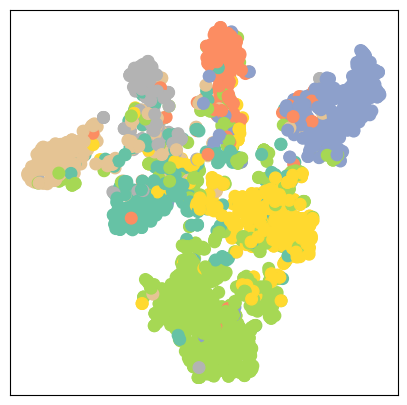

In [80]:
# visualization
model.eval()
out = model(data['x'], data['edge_index'])
visualize(out, data['y'])

### Using GAT

In [82]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

In [169]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels=dataset.num_node_features, out_channels=hidden_channels, heads=heads)
        self.conv2 = GATConv(in_channels=hidden_channels * heads, out_channels=dataset.num_classes, heads=1)
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv1(x, edge_index)
        # x = F.elu(x)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        return x

In [170]:
model = GAT(hidden_channels=16, heads=8)

In [171]:
print(model)

GAT(
  (conv1): GATConv(1433, 16, heads=8)
  (conv2): GATConv(128, 7, heads=1)
)


In [172]:
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [173]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data['x'], data['edge_index'])
    loss = criterion(out[data['train_mask']], data['y'][data['train_mask']])
    loss.backward()
    optimizer.step()
    
    return loss

def test():
    model.eval()
    out = model(data['x'], data['edge_index'])
    pred = out.argmax(dim = 1)
    test_correct = pred[data['test_mask']] == data['y'][data['test_mask']]
    test_acc = test_correct.sum().item() / data['test_mask'].sum().item()
    return test_acc

In [174]:
test()

0.225

In [175]:
for epoch in range(1,101):
    loss = train()
    if epoch % 10 == 0:
        print(f"epoch = {epoch} :: train_loss = {loss}")

epoch = 10 :: train_loss = 1.7174220085144043
epoch = 20 :: train_loss = 1.2291244268417358
epoch = 30 :: train_loss = 0.7351703643798828
epoch = 40 :: train_loss = 0.4622311592102051
epoch = 50 :: train_loss = 0.39531639218330383
epoch = 60 :: train_loss = 0.3148467242717743
epoch = 70 :: train_loss = 0.30729150772094727
epoch = 80 :: train_loss = 0.26247721910476685
epoch = 90 :: train_loss = 0.24628619849681854
epoch = 100 :: train_loss = 0.2022765576839447


In [176]:
test()

0.793